In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [2]:
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Using TensorFlow backend.


## 1. Upload data

In [3]:
est_1 = pd.read_csv('Data/dataIDEAM.csv')
est_1 = est_1.rename(columns = {'Unnamed: 0': 'Date'})
est_1 = est_1[['Hour','GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]

In [4]:
var = est_1[['GHI','DHI','DNI','Wind Speed','Temperature','Solar Zenith Angle']]
est_1_prom = []
for i in range(0,len(est_1),2):
    est_1_prom.append(np.array((var.iloc[i] + var.iloc[i+1])/2))

hora = []
for i in range(0,len(est_1),2):
    hora.append(est_1['Hour'][i])

est_1_prom = np.column_stack((hora,est_1_prom))
est_1_prom = pd.DataFrame(est_1_prom)
est_1_prom = est_1_prom.rename(columns={0:'Hour',1:'GHI',2:'DHI',3:'DNI',4:'Wind Speed',5:'Temperature',6:'Solar Zenith Angle'})

## 2. Site-adaptation

In [5]:
import joblib
forest_reg = joblib.load("best_regressor.pkl")

### 2.1 Prepare data for site-adaptation (regression model)

In [6]:
from sklearn.preprocessing import StandardScaler

X = est_1_prom
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.astype('float64'))

### 2.2 Applying regression model

In [7]:
y_reg = forest_reg.predict(X_scaled)
y_reg = pd.DataFrame(np.round(y_reg))
GHI = y_reg.replace(y_reg[y_reg[0]<=0],0)

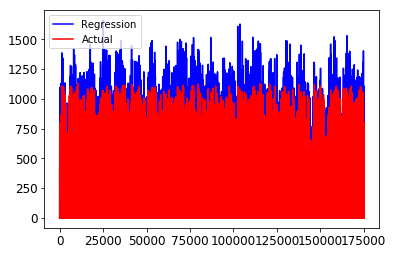

In [8]:
%matplotlib inline
plt.plot(np.array(GHI),'b', label='Regression')
plt.plot(est_1_prom['GHI'],'r', label='Actual')
plt.legend()
plt.show()

# 3. Forecasting

In [9]:
from keras import backend as K
import keras
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [10]:
# divide the input vector into samples

def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

## 3.1. Dividing into training, test, and validation sets; and normalizing data

In [11]:
from sklearn.preprocessing import StandardScaler

# 14 first years for training
# 15-17 years for validation
# last 3 years for testing

X = np.array(GHI[0])
scaler = StandardScaler().fit(X.reshape(-1, 1))
X = scaler.transform(X.reshape(-1, 1))
X = X.ravel()

X_train = X[:122640]
X_val = X[122640:148920]
X_test = X[148920:]

In [12]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(175200,)
(122640,)
(26280,)
(26280,)


## 3.2 Daily forecasting

### 3.2.1 Prepare data with 168 input data

In [48]:
# Choose number of input and output steps
n_steps_in_d = 168
n_steps_out_d = 24
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122449, 168)
(122449, 24)
(26089, 168)
(26089, 24)


In [49]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122449, 168, 1)
(122449, 24, 1)
(26089, 168, 1)
(26089, 24, 1)


### Training model: 12 neurons in encoder and decoder

In [14]:
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from time import time

# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(12, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(12, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 122449 samples, validate on 26089 samples
Epoch 1/100
122449/122449 [==============================] - 19s 154us/step - loss: 0.2711 - val_loss: 0.1328
Epoch 2/100
122449/122449 [==============================] - 11s 90us/step - loss: 0.1521 - val_loss: 0.1217
Epoch 3/100
122449/122449 [==============================] - 11s 93us/step - loss: 0.1448 - val_loss: 0.1175
Epoch 4/100
122449/122449 [==============================] - 11s 87us/step - loss: 0.1418 - val_loss: 0.1210
Epoch 5/100
122449/122449 [==============================] - 10s 85us/step - loss: 0.1401 - val_loss: 0.1181
Epoch 6/100
122449/122449 [==============================] - 11s 86us/step - loss: 0.1391 - val_loss: 0.1151
Epoch 7/100
122449/122449 [==============================] - 11s 86us/step - loss: 0.1385 - val_loss: 0.1157
Epoch 8/100
122449/122449 [==============================] - 11s 

In [21]:
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 12)                720       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 12)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 24, 12)            1248      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             13        
Total params: 1,981
Trainable params: 1,981
Non-trainable params: 0
_________________________________________________________________


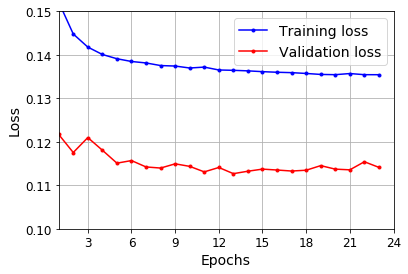

In [20]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(history.epoch), 0.1, 0.15])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 24 neurons in encoder and decoder

In [50]:
# define the model
# encoder
model_d = Sequential()
# model_d.add(Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=(n_steps_in_d, n_features)))
# model_d.add(CuDNNLSTM(24))
model_d.add(CuDNNLSTM(24, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(24, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122449 samples, validate on 26089 samples
Epoch 1/100
122449/122449 [==============================] - 13s 107us/step - loss: 0.2192 - val_loss: 0.1235
Epoch 2/100
122449/122449 [==============================] - 11s 91us/step - loss: 0.1417 - val_loss: 0.1163
Epoch 3/100
122449/122449 [==============================] - 11s 90us/step - loss: 0.1391 - val_loss: 0.1168
Epoch 4/100
122449/122449 [==============================] - 12s 99us/step - loss: 0.1379 - val_loss: 0.1146
Epoch 5/100
122449/122449 [==============================] - 12s 97us/step - loss: 0.1374 - val_loss: 0.1154
Epoch 6/100
122449/122449 [==============================] - 11s 92us/step - loss: 0.1368 - val_loss: 0.1133
Epoch 7/100
122449/122449 [==============================] - 11s 88us/step - loss: 0.1363 - val_loss: 0.1148
Epoch 8/100
122449/122449 [==============================] - 11s 93us/step - loss: 0.1365 - val_loss: 0.1154
Epoch 9/100
122449/122449 [==============================] - 11s 93us/step -

In [51]:
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_13 (CuDNNLSTM)    (None, 24)                2592      
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 24, 24)            0         
_________________________________________________________________
cu_dnnlstm_14 (CuDNNLSTM)    (None, 24, 24)            4800      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 24, 1)             25        
Total params: 7,417
Trainable params: 7,417
Non-trainable params: 0
_________________________________________________________________


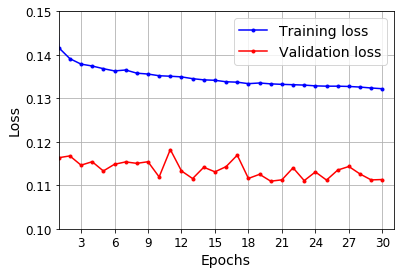

In [51]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

###  Training model: 168 neurons in encoder and decoder

In [31]:
# define the model
model_d = Sequential()
model_d.add(CuDNNLSTM(168, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

model_d.add(CuDNNLSTM(168, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
start = time()
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122449 samples, validate on 26089 samples
Epoch 1/100
122449/122449 [==============================] - 14s 111us/step - loss: 0.1761 - val_loss: 0.1170
Epoch 2/100
122449/122449 [==============================] - 13s 103us/step - loss: 0.1410 - val_loss: 0.1170
Epoch 3/100
122449/122449 [==============================] - 13s 104us/step - loss: 0.1382 - val_loss: 0.1145
Epoch 4/100
122449/122449 [==============================] - 13s 103us/step - loss: 0.1371 - val_loss: 0.1140
Epoch 5/100
122449/122449 [==============================] - 13s 103us/step - loss: 0.1362 - val_loss: 0.1132
Epoch 6/100
122449/122449 [==============================] - 13s 104us/step - loss: 0.1357 - val_loss: 0.1139
Epoch 7/100
122449/122449 [==============================] - 13s 105us/step - loss: 0.1348 - val_loss: 0.1126
Epoch 8/100
122449/122449 [==============================] - 13s 103us/step - loss: 0.1342 - val_loss: 0.1157
Epoch 9/100
122449/122449 [==============================] - 13s 103u

In [38]:
model_d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_29 (CuDNNLSTM)    (None, 168)               114912    
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 24, 168)           0         
_________________________________________________________________
cu_dnnlstm_30 (CuDNNLSTM)    (None, 24, 168)           227136    
_________________________________________________________________
time_distributed_10 (TimeDis (None, 24, 1)             169       
Total params: 342,217
Trainable params: 342,217
Non-trainable params: 0
_________________________________________________________________


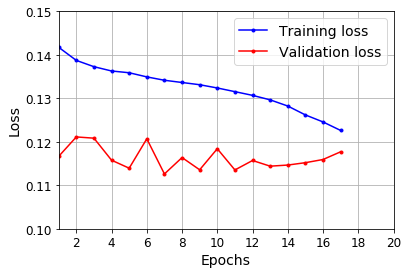

In [40]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 3.2.2 Prepare data with 72 input data

In [32]:
# Choose number of input and output steps
n_steps_in_d = 72
n_steps_out_d = 24
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122545, 72)
(122545, 24)
(26185, 72)
(26185, 24)


In [33]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122545, 72, 1)
(122545, 24, 1)
(26185, 72, 1)
(26185, 24, 1)


###  Training model: 12 neurons in encoder and decoder

In [34]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(12, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(12, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122545 samples, validate on 26185 samples
Epoch 1/100
122545/122545 [==============================] - 9s 75us/step - loss: 0.2651 - val_loss: 0.1274
Epoch 2/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1476 - val_loss: 0.1197
Epoch 3/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1426 - val_loss: 0.1204
Epoch 4/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1407 - val_loss: 0.1153
Epoch 5/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1395 - val_loss: 0.1208
Epoch 6/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1386 - val_loss: 0.1170
Epoch 7/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1378 - val_loss: 0.1162
Epoch 8/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1375 - val_loss: 0.1148
Epoch 9/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1

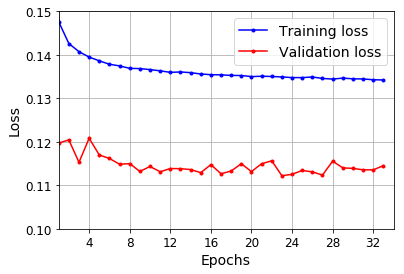

In [35]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

###  Training model: 24 neurons in encoder and decoder

In [36]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(24, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(24, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122545 samples, validate on 26185 samples
Epoch 1/100
122545/122545 [==============================] - 9s 77us/step - loss: 0.2224 - val_loss: 0.1239
Epoch 2/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1428 - val_loss: 0.1213
Epoch 3/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1402 - val_loss: 0.1175
Epoch 4/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1391 - val_loss: 0.1176
Epoch 5/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1382 - val_loss: 0.1165
Epoch 6/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1378 - val_loss: 0.1158
Epoch 7/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1370 - val_loss: 0.1143
Epoch 8/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1368 - val_loss: 0.1134
Epoch 9/100
122545/122545 [==============================] - 8s 67us/step - loss: 0.1

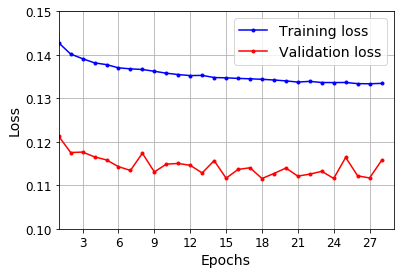

In [37]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

###  Training model: 168 neurons in encoder and decoder

In [38]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(168, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(168, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train el model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122545 samples, validate on 26185 samples
Epoch 1/100
122545/122545 [==============================] - 10s 82us/step - loss: 0.1721 - val_loss: 0.1183
Epoch 2/100
122545/122545 [==============================] - 9s 70us/step - loss: 0.1414 - val_loss: 0.1169
Epoch 3/100
122545/122545 [==============================] - 9s 69us/step - loss: 0.1390 - val_loss: 0.1147
Epoch 4/100
122545/122545 [==============================] - 9s 71us/step - loss: 0.1378 - val_loss: 0.1145
Epoch 5/100
122545/122545 [==============================] - 9s 71us/step - loss: 0.1364 - val_loss: 0.1170
Epoch 6/100
122545/122545 [==============================] - 9s 72us/step - loss: 0.1360 - val_loss: 0.1170
Epoch 7/100
122545/122545 [==============================] - 9s 70us/step - loss: 0.1351 - val_loss: 0.1167
Epoch 8/100
122545/122545 [==============================] - 9s 71us/step - loss: 0.1348 - val_loss: 0.1159
Epoch 9/100
122545/122545 [==============================] - 9s 70us/step - loss: 0.

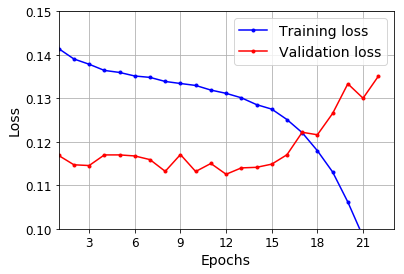

In [39]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 3.2.3 Prepare data with 24 input data

In [40]:
# Choose number of input and output steps
n_steps_in_d = 24
n_steps_out_d = 24
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_d, n_steps_out_d)
X_v, y_v = split_sequence(X_val, n_steps_in_d, n_steps_out_d)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122593, 24)
(122593, 24)
(26233, 24)
(26233, 24)


In [41]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122593, 24, 1)
(122593, 24, 1)
(26233, 24, 1)
(26233, 24, 1)


### Training model: 12 neurons in encoder and decoder

In [42]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(12, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(12, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122593 samples, validate on 26233 samples
Epoch 1/100
122593/122593 [==============================] - 8s 69us/step - loss: 0.2826 - val_loss: 0.1354
Epoch 2/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1561 - val_loss: 0.1294
Epoch 3/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1486 - val_loss: 0.1217
Epoch 4/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1448 - val_loss: 0.1190
Epoch 5/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1428 - val_loss: 0.1184
Epoch 6/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1412 - val_loss: 0.1193
Epoch 7/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1405 - val_loss: 0.1176
Epoch 8/100
122593/122593 [==============================] - 7s 56us/step - loss: 0.1398 - val_loss: 0.1187
Epoch 9/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1

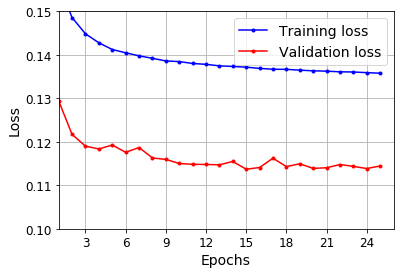

In [43]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

###  Training model: 24 neurons in encoder and decoder

In [44]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(24, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(24, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122593 samples, validate on 26233 samples
Epoch 1/100
122593/122593 [==============================] - 9s 73us/step - loss: 0.2137 - val_loss: 0.1292
Epoch 2/100
122593/122593 [==============================] - 7s 59us/step - loss: 0.1460 - val_loss: 0.1201
Epoch 3/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1421 - val_loss: 0.1199
Epoch 4/100
122593/122593 [==============================] - 7s 58us/step - loss: 0.1405 - val_loss: 0.1160
Epoch 5/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1396 - val_loss: 0.1149
Epoch 6/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1390 - val_loss: 0.1205
Epoch 7/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1385 - val_loss: 0.1156
Epoch 8/100
122593/122593 [==============================] - 7s 58us/step - loss: 0.1382 - val_loss: 0.1146
Epoch 9/100
122593/122593 [==============================] - 7s 57us/step - loss: 0.1

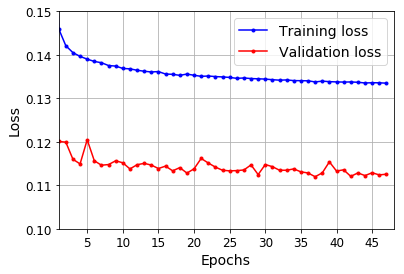

In [45]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 168 neurons in encoder and decoder

In [46]:
# define the model
# encoder
model_d = Sequential()
model_d.add(CuDNNLSTM(168, input_shape=(n_steps_in_d, n_features)))
model_d.add(RepeatVector(n_steps_out_d))

# decoder
model_d.add(CuDNNLSTM(168, return_sequences=True))
model_d.add(TimeDistributed(Dense(1)))
model_d.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_d.fit(X_t, y_t, epochs=100, batch_size=128, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122593 samples, validate on 26233 samples
Epoch 1/100
122593/122593 [==============================] - 9s 74us/step - loss: 0.1769 - val_loss: 0.1250
Epoch 2/100
122593/122593 [==============================] - 7s 59us/step - loss: 0.1436 - val_loss: 0.1187
Epoch 3/100
122593/122593 [==============================] - 7s 58us/step - loss: 0.1401 - val_loss: 0.1186
Epoch 4/100
122593/122593 [==============================] - 7s 58us/step - loss: 0.1393 - val_loss: 0.1147
Epoch 5/100
122593/122593 [==============================] - 7s 58us/step - loss: 0.1381 - val_loss: 0.1159
Epoch 6/100
122593/122593 [==============================] - 7s 60us/step - loss: 0.1377 - val_loss: 0.1131
Epoch 7/100
122593/122593 [==============================] - 7s 60us/step - loss: 0.1372 - val_loss: 0.1139
Epoch 8/100
122593/122593 [==============================] - 7s 59us/step - loss: 0.1366 - val_loss: 0.1148
Epoch 9/100
122593/122593 [==============================] - 7s 60us/step - loss: 0.1

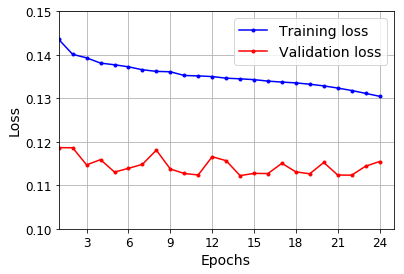

In [47]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 3.2.4 Forecasting one day in the test set

In [156]:
# Normalize test set
scaler = StandardScaler()
scaler.fit(X_test.reshape(-1, 1))
X_test = scaler.transform(X_test.reshape(-1, 1))
X_test = X_test.ravel()

# Forecasting the test set
X_test_, y_test = split_sequence(X_test, n_steps_in_d, n_steps_out_d)
y_test = scaler.inverse_transform(y_test)

print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_test_.shape)
print(y_test.shape)

(175200,)
(166440,)
(8760,)
(8569, 168)
(8569, 24)


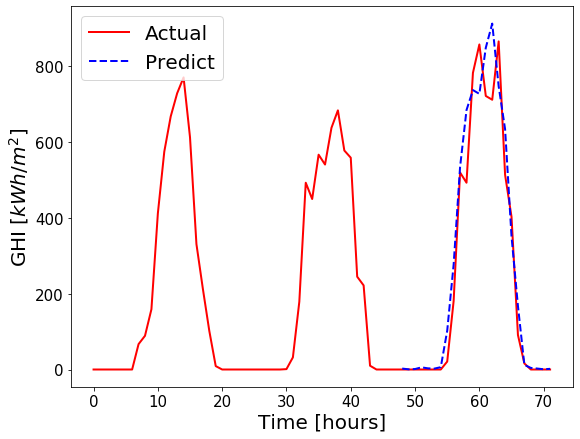

Root mean square error:  83.10449634134855
Mean absolute error:  53.73958577712377
R-Squared:  0.934169787483287


In [189]:
X = np.array(GHI[0])
test_size = 365*24
X_train = X[:(len(X)-test_size)]
a = X_train[len(X_train)-48:len(X_train)]
b = np.hstack((a,actual))

time = np.arange(72)

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predict_1_day_01012017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

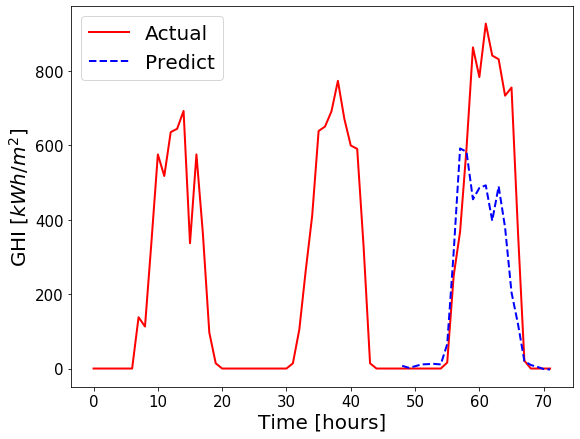

Root mean square error:  233.5093033766153
Mean absolute error:  146.2146664907535
R-Squared:  0.5864709582075659


In [190]:
predict = 24*31
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

var = scaler.inverse_transform(X_test)
actual = y_test[predict]
a = var[predict-48:predict]
b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predic_1_day_01012012.png', format='png', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

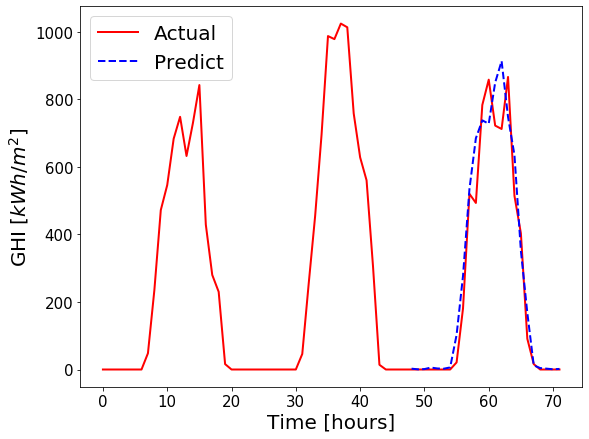

Root mean square error:  83.10449634134855
Mean absolute error:  53.73958577712377
R-Squared:  0.934169787483287


In [192]:
predict = (24*31) + (24*28)
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

# var = scaler.inverse_transform(X_test)
actual = y_test[predict]
a = var[predict-48:predict]
b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_1_day_01032017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

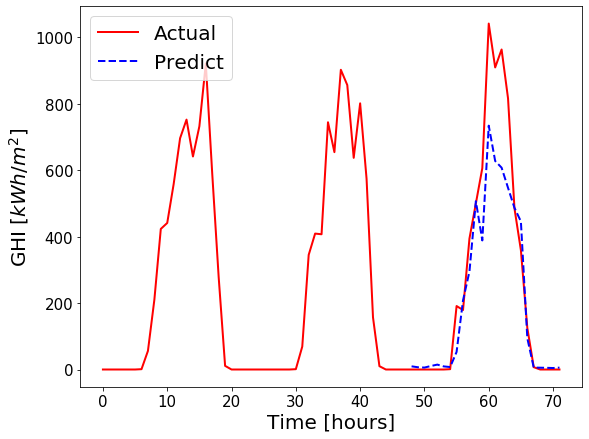

Root mean square error:  138.28338378435595
Mean absolute error:  79.48989208539327
R-Squared:  0.842945452425438


In [193]:
predict = (24*31) + (24*28) + (24*31)
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

# var = scaler.inverse_transform(X_test)
actual = y_test[predict]
a = var[predict-48:predict]
b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predict_1_day_01042017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

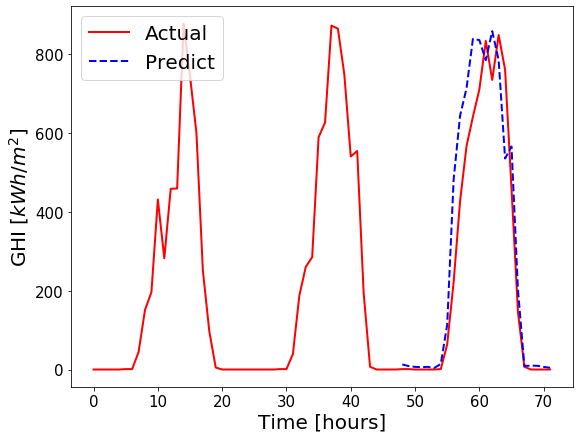

Root mean square error:  108.20728065577266
Mean absolute error:  71.21677319208781
R-Squared:  0.8882529773818483


In [195]:
predict = (24*31) + (24*28) + (24*31) + (24*30)
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

# var = scaler.inverse_transform(X_test)
actual = y_test[predict]
a = var[predict-48:predict]
b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_1_day_01052017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

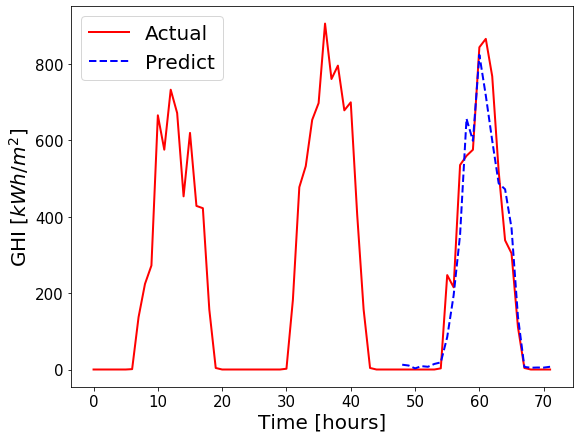

Root mean square error:  77.90344238974932
Mean absolute error:  49.065457145373024
R-Squared:  0.9315867990897784


In [197]:
predict = (24*31) + (24*28) + (24*31) + (24*30) + (24*31) + (24*30) + (24*31) + (24*31) + (24*30) + (24*31) + (24*30)
x_input = X_test_[predict].reshape((1, n_steps_in_d, n_features))
yhat_norm_d = model_d.predict(x_input, verbose=0)
yhat_d = scaler.inverse_transform(yhat_norm_d)
yhat_d = yhat_d[0]

# var = scaler.inverse_transform(X_test)
actual = y_test[predict]
a = var[predict-48:predict]
b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(b,'r',  label='Actual', linewidth=2)
plt.plot(time[48:], yhat_d.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_1_day_01122017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_d))
mae = mean_absolute_error(actual, yhat_d)
r2 = r2_score(actual, yhat_d)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

In [86]:
model_d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 168)               114912    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 24, 168)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 24, 168)           227136    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 24, 1)             169       
Total params: 342,217
Trainable params: 342,217
Non-trainable params: 0
_________________________________________________________________


## 3.3 Weekly forecasting

### 3.3.1 Prepare data with 672 input data

In [13]:
# Choose number of input and output steps
n_steps_in_w = 672
n_steps_out_w = 168
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_w, n_steps_out_w)
X_v, y_v = split_sequence(X_val, n_steps_in_w, n_steps_out_w)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(121801, 672)
(121801, 168)
(25441, 672)
(25441, 168)


In [14]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(121801, 672, 1)
(121801, 168, 1)
(25441, 672, 1)
(25441, 168, 1)


### Training model: 12 neurons in encoder and decoder

In [15]:
from keras.layers import LSTM, Dense, Bidirectional, Input,Dropout,BatchNormalization, CuDNNGRU, CuDNNLSTM
from keras.models import Sequential
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from time import time

# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(12, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(12, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 121801 samples, validate on 25441 samples
Epoch 1/100
121801/121801 [==============================] - 104s 851us/step - loss: 0.2550 - val_loss: 0.1547
Epoch 2/100
121801/121801 [==============================] - 101s 832us/step - loss: 0.1799 - val_loss: 0.1531
Epoch 3/100
121801/121801 [==============================] - 100s 825us/step - loss: 0.1772 - val_loss: 0.1497
Epoch 4/100
121801/121801 [==============================] - 100s 825us/step - loss: 0.1756 - val_loss: 0.1487
Epoch 5/100
121801/121801 [==============================] - 104s 851us/step - loss: 0.1742 - val_loss: 0.1483
Epoch 6/100
121801/121801 [==============================] - 104s 856us/step - loss: 0.1734 - val_loss: 0.1528
Epoch 7/100
121801/121801 [==============================] - 101s 831us/step - loss: 0.1726 - val_loss: 0.1447
Epoch 8/100
121801/121801 [=========================

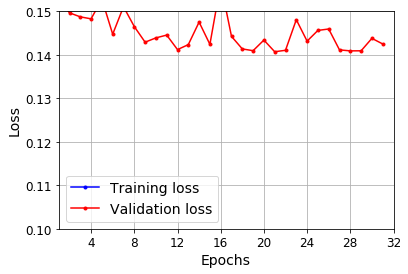

In [16]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["val_loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 24 neurons in encoder and decoder

In [17]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(24, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(24, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 121801 samples, validate on 25441 samples
Epoch 1/100
121801/121801 [==============================] - 116s 953us/step - loss: 0.2270 - val_loss: 0.1482
Epoch 2/100
121801/121801 [==============================] - 115s 942us/step - loss: 0.1780 - val_loss: 0.1486
Epoch 3/100
121801/121801 [==============================] - 115s 946us/step - loss: 0.1749 - val_loss: 0.1425
Epoch 4/100
121801/121801 [==============================] - 115s 941us/step - loss: 0.1731 - val_loss: 0.1440
Epoch 5/100
121801/121801 [==============================] - 115s 942us/step - loss: 0.1717 - val_loss: 0.1422
Epoch 6/100
121801/121801 [==============================] - 116s 949us/step - loss: 0.1707 - val_loss: 0.1450
Epoch 7/100
121801/121801 [==============================] - 115s 946us/step - loss: 0.1701 - val_loss: 0.1407
Epoch 8/100
121801/121801 [==============================] - 116s 952us/step - loss: 0.1694 - val_loss: 0.1423
Epoch 9/100
121801/121801 [==============================] - 

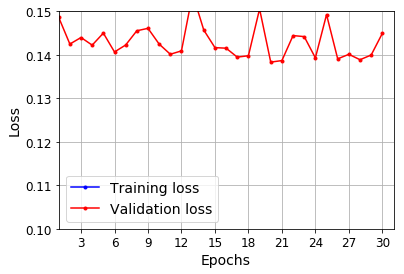

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 168 neurons in encoder and decoder

In [19]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(168, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(168, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 121801 samples, validate on 25441 samples
Epoch 1/100
121801/121801 [==============================] - 129s 1ms/step - loss: 0.2173 - val_loss: 0.1467
Epoch 2/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.1788 - val_loss: 0.1728
Epoch 3/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.1740 - val_loss: 0.1500
Epoch 4/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.1709 - val_loss: 0.1460
Epoch 5/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.1695 - val_loss: 0.1416
Epoch 6/100
121801/121801 [==============================] - 129s 1ms/step - loss: 0.1689 - val_loss: 0.1637
Epoch 7/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.2222 - val_loss: 0.1458
Epoch 8/100
121801/121801 [==============================] - 128s 1ms/step - loss: 0.3748 - val_loss: 0.2185
Epoch 9/100
121801/121801 [==============================] - 128s 1ms/step - 

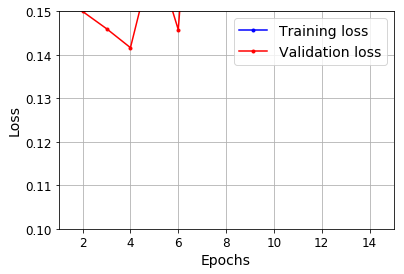

In [20]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 3.3.2 Prepare data with 336 input data

In [43]:
# Choose number of input and output steps
n_steps_in_w = 336
n_steps_out_w = 168
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_w, n_steps_out_w)
X_v, y_v = split_sequence(X_val, n_steps_in_w, n_steps_out_w)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122137, 336)
(122137, 168)
(25777, 336)
(25777, 168)


In [44]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122137, 336, 1)
(122137, 168, 1)
(25777, 336, 1)
(25777, 168, 1)


### Training model: 12 neurons in encoder and decoder

In [23]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(12, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(12, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122137 samples, validate on 25777 samples
Epoch 1/100
122137/122137 [==============================] - 69s 567us/step - loss: 0.2443 - val_loss: 0.1524
Epoch 2/100
122137/122137 [==============================] - 68s 556us/step - loss: 0.1807 - val_loss: 0.1554
Epoch 3/100
122137/122137 [==============================] - 68s 560us/step - loss: 0.1774 - val_loss: 0.1486
Epoch 4/100
122137/122137 [==============================] - 68s 559us/step - loss: 0.1754 - val_loss: 0.1505
Epoch 5/100
122137/122137 [==============================] - 68s 557us/step - loss: 0.1742 - val_loss: 0.1509
Epoch 6/100
122137/122137 [==============================] - 68s 557us/step - loss: 0.1733 - val_loss: 0.1448
Epoch 7/100
122137/122137 [==============================] - 68s 559us/step - loss: 0.1726 - val_loss: 0.1487
Epoch 8/100
122137/122137 [==============================] - 68s 559us/step - loss: 0.1722 - val_loss: 0.1498
Epoch 9/100
122137/122137 [==============================] - 68s 559u

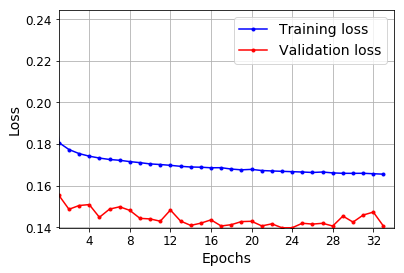

In [30]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, len(history.epoch), min(history.history["val_loss"]), max(history.history["loss"])])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)


plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 24 neurons in encoder and decoder

In [47]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(24, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(24, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# trian the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 122137 samples, validate on 25777 samples
Epoch 1/100
122137/122137 [==============================] - 73s 597us/step - loss: 0.2245 - val_loss: 0.1472
Epoch 2/100
122137/122137 [==============================] - 71s 581us/step - loss: 0.1770 - val_loss: 0.1486
Epoch 3/100
122137/122137 [==============================] - 71s 580us/step - loss: 0.1742 - val_loss: 0.1476
Epoch 4/100
122137/122137 [==============================] - 71s 578us/step - loss: 0.1721 - val_loss: 0.1463
Epoch 5/100
122137/122137 [==============================] - 71s 579us/step - loss: 0.1712 - val_loss: 0.1453
Epoch 6/100
122137/122137 [==============================] - 71s 580us/step - loss: 0.1709 - val_loss: 0.1408
Epoch 7/100
122137/122137 [==============================] - 71s 578us/step - loss: 0.1694 - val_loss: 0.1435
Epoch 8/100
122137/122137 [==============================] - 71s 580us/step - loss: 0.1692 - val_loss: 0.1399
Epoch 9/100
122137/122137 [==============================] - 71s 579u

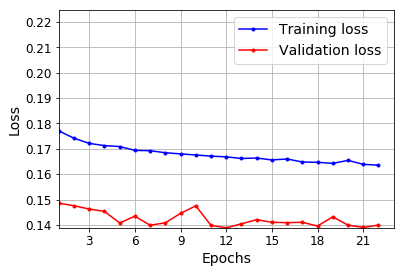

In [48]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 168 neurons in encoder and decoder

In [33]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(168, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(168, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 122137 samples, validate on 25777 samples
Epoch 1/100
122137/122137 [==============================] - 80s 652us/step - loss: 0.2078 - val_loss: 0.1510
Epoch 2/100
122137/122137 [==============================] - 78s 641us/step - loss: 0.1799 - val_loss: 0.1565
Epoch 3/100
122137/122137 [==============================] - 79s 644us/step - loss: 0.1736 - val_loss: 0.1504
Epoch 4/100
122137/122137 [==============================] - 79s 644us/step - loss: 0.1712 - val_loss: 0.1571
Epoch 5/100
122137/122137 [==============================] - 79s 646us/step - loss: 0.1691 - val_loss: 0.1389
Epoch 6/100
122137/122137 [==============================] - 79s 650us/step - loss: 0.2358 - val_loss: 0.1969
Epoch 7/100
122137/122137 [==============================] - 79s 650us/step - loss: 0.4351 - val_loss: 0.4284
Epoch 8/100
122137/122137 [==============================] - 79s 651us/step - loss: 0.4412 - val_loss: 0.3546
Epoch 9/100
122137/122137 [==============================] - 79s 649u

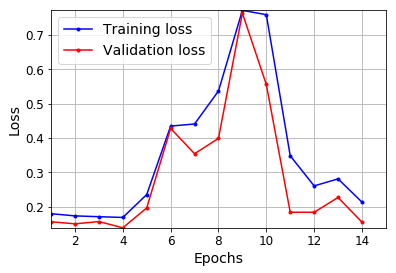

In [34]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 3.3.3 Prepare data with 168 input data

In [35]:
# Choose number of input and ouput steps
n_steps_in_w = 168
n_steps_out_w = 168
# Divide into samples
X_t, y_t = split_sequence(X_train, n_steps_in_w, n_steps_out_w)
X_v, y_v = split_sequence(X_val, n_steps_in_w, n_steps_out_w)

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122305, 168)
(122305, 168)
(25945, 168)
(25945, 168)


In [36]:
# Resize [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X_t = X_t.reshape((X_t.shape[0], X_t.shape[1], n_features))
y_t = y_t.reshape((y_t.shape[0], y_t.shape[1], n_features))
X_v = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))
y_v = y_v.reshape((y_v.shape[0], y_v.shape[1], n_features))

print(X_t.shape)
print(y_t.shape)
print(X_v.shape)
print(y_v.shape)

(122305, 168, 1)
(122305, 168, 1)
(25945, 168, 1)
(25945, 168, 1)


### Training model: 12 neurons in encoder and decoder

In [37]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(12, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(12, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start)) 

Train on 122305 samples, validate on 25945 samples
Epoch 1/100
122305/122305 [==============================] - 54s 443us/step - loss: 0.2370 - val_loss: 0.1574
Epoch 2/100
122305/122305 [==============================] - 52s 423us/step - loss: 0.1783 - val_loss: 0.1617
Epoch 3/100
122305/122305 [==============================] - 53s 429us/step - loss: 0.1753 - val_loss: 0.1538
Epoch 4/100
122305/122305 [==============================] - 53s 429us/step - loss: 0.1737 - val_loss: 0.1468
Epoch 5/100
122305/122305 [==============================] - 53s 430us/step - loss: 0.1731 - val_loss: 0.1457
Epoch 6/100
122305/122305 [==============================] - 53s 431us/step - loss: 0.1722 - val_loss: 0.1455
Epoch 7/100
122305/122305 [==============================] - 52s 428us/step - loss: 0.1716 - val_loss: 0.1513
Epoch 8/100
122305/122305 [==============================] - 53s 433us/step - loss: 0.1711 - val_loss: 0.1438
Epoch 9/100
122305/122305 [==============================] - 53s 431u

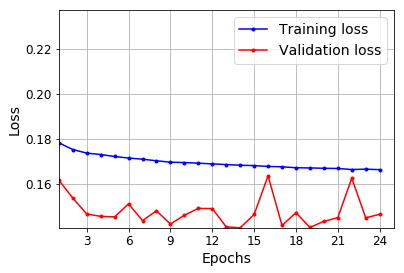

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 24 neurons in encoder and decoder

In [39]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(24, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(24, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 122305 samples, validate on 25945 samples
Epoch 1/100
122305/122305 [==============================] - 56s 456us/step - loss: 0.2377 - val_loss: 0.1637
Epoch 2/100
122305/122305 [==============================] - 53s 434us/step - loss: 0.1787 - val_loss: 0.1911
Epoch 3/100
122305/122305 [==============================] - 53s 431us/step - loss: 0.1756 - val_loss: 0.1552
Epoch 4/100
122305/122305 [==============================] - 53s 432us/step - loss: 0.1741 - val_loss: 0.1561
Epoch 5/100
122305/122305 [==============================] - 53s 432us/step - loss: 0.1725 - val_loss: 0.1481
Epoch 6/100
122305/122305 [==============================] - 53s 433us/step - loss: 0.1712 - val_loss: 0.1474
Epoch 7/100
122305/122305 [==============================] - 53s 432us/step - loss: 0.1705 - val_loss: 0.1506
Epoch 8/100
122305/122305 [==============================] - 53s 434us/step - loss: 0.1699 - val_loss: 0.1807
Epoch 9/100
122305/122305 [==============================] - 53s 437u

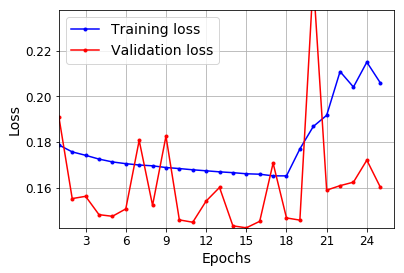

In [40]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Training model: 168 neurons in encoder and decoder

In [41]:
# Define the model
model_w = Sequential()
model_w.add(CuDNNLSTM(168, input_shape=(n_steps_in_w, n_features)))
model_w.add(RepeatVector(n_steps_out_w))

model_w.add(CuDNNLSTM(168, return_sequences=True))
model_w.add(TimeDistributed(Dense(1)))
model_w.compile(optimizer='adam', loss='mse')

# train the model
start = time()
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
history = model_w.fit(X_t, y_t, epochs=100, batch_size=32, verbose=1,
           validation_data=(X_v, y_v), callbacks=[early_stopping])
print("The model took %.2f seconds for training."% (time() - start))

Train on 122305 samples, validate on 25945 samples
Epoch 1/100
122305/122305 [==============================] - 61s 495us/step - loss: 0.2153 - val_loss: 0.2420
Epoch 2/100
122305/122305 [==============================] - 59s 481us/step - loss: 0.1775 - val_loss: 0.1451
Epoch 3/100
122305/122305 [==============================] - 59s 481us/step - loss: 0.1733 - val_loss: 0.1486
Epoch 4/100
122305/122305 [==============================] - 59s 483us/step - loss: 0.1705 - val_loss: 0.1580
Epoch 5/100
122305/122305 [==============================] - 59s 483us/step - loss: 0.3467 - val_loss: 0.1818
Epoch 6/100
122305/122305 [==============================] - 59s 484us/step - loss: 0.2276 - val_loss: 0.1537
Epoch 7/100
122305/122305 [==============================] - 59s 486us/step - loss: 0.1975 - val_loss: 0.1437
Epoch 8/100
122305/122305 [==============================] - 59s 486us/step - loss: 0.2692 - val_loss: 0.8369
Epoch 9/100
122305/122305 [==============================] - 60s 488u

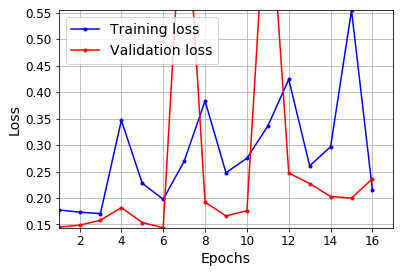

In [42]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

## 3.3.4 Forecasting one week in the test set

Root mean square error:  82.33045348732492
Mean absolute error:  45.648809523809526
R-Squared:  0.8766708098714832


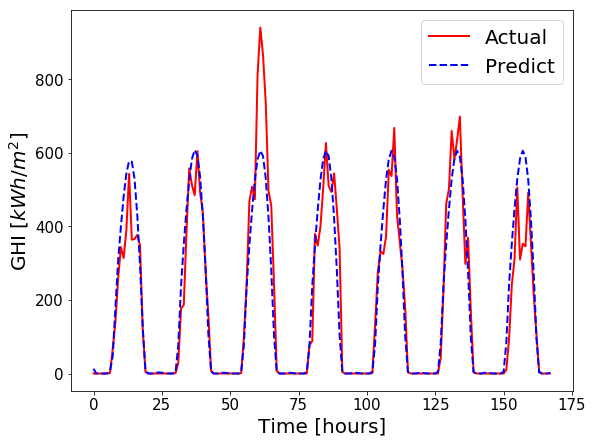

In [167]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_test_, y_test = split_sequence(X_test, n_steps_in_w, n_steps_out_w)
y_test = scaler.inverse_transform(y_test)

week = 672*34
# 672 = one month

x_input = X_test_[week].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)
actual = y_test[week]

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='best', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
# plt.savefig('Figuras_Informe/predict_week_442015.eps', format='eps', dpi=300)
plt.show() 

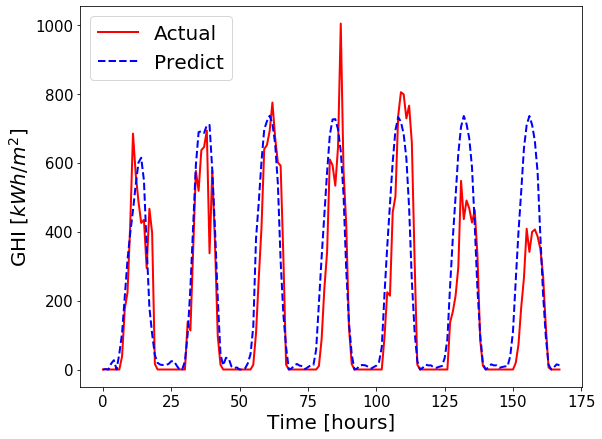

Root mean square error:  136.01363289513787
Mean absolute error:  85.92261904761905
R-Squared:  0.7197682044672723


In [92]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
predict = 0
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01022017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

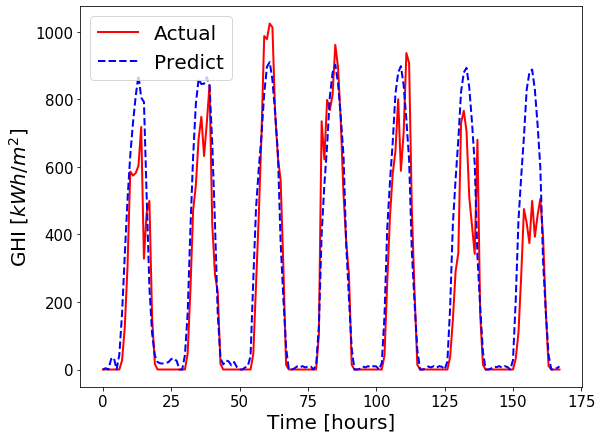

Root mean square error:  144.0443673383474
Mean absolute error:  89.64880952380952
R-Squared:  0.7872119339249053


In [93]:
predict = 672
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01032017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

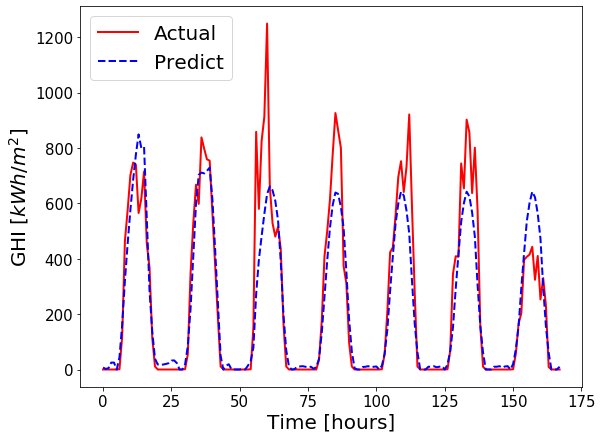

Root mean square error:  125.37472404185554
Mean absolute error:  71.04761904761905
R-Squared:  0.838375525569512


In [94]:
predict = 672*2
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01042017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

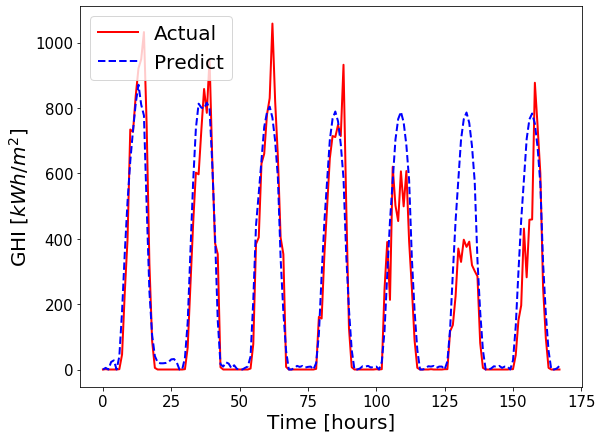

Root mean square error:  124.94944215657026
Mean absolute error:  75.98214285714286
R-Squared:  0.8291358964385495


In [95]:
predict = 672*3
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01052017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

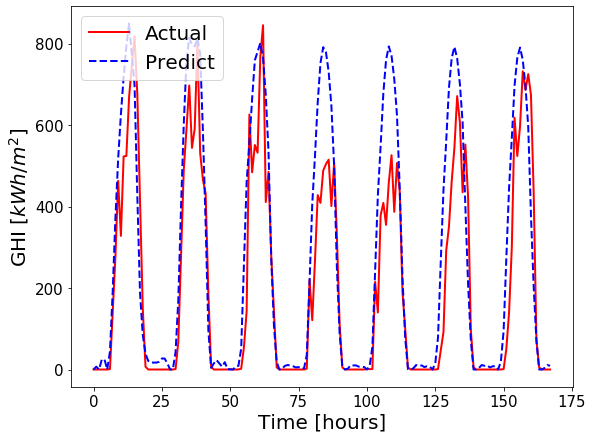

Root mean square error:  141.99712857593116
Mean absolute error:  90.32738095238095
R-Squared:  0.692899103700549


In [96]:
predict = 672*4
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01062017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

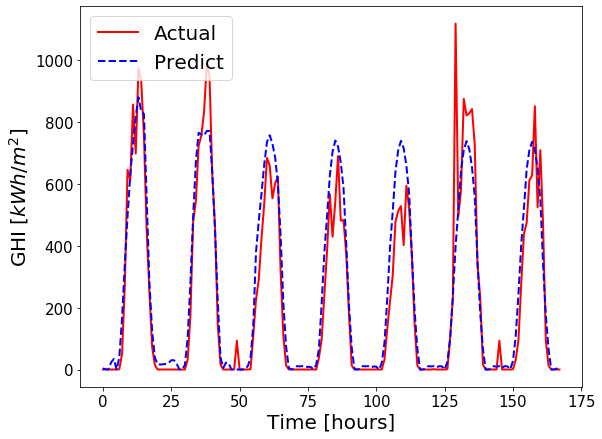

Root mean square error:  103.20198064729092
Mean absolute error:  62.041666666666664
R-Squared:  0.8829078416261712


In [97]:
predict = 672*5
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01072017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

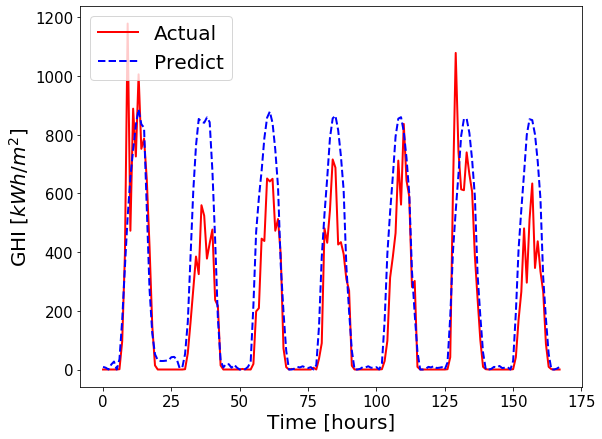

Root mean square error:  173.71884784109668
Mean absolute error:  109.36904761904762
R-Squared:  0.6163106744621056


In [98]:
predict = 672*6
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01082017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

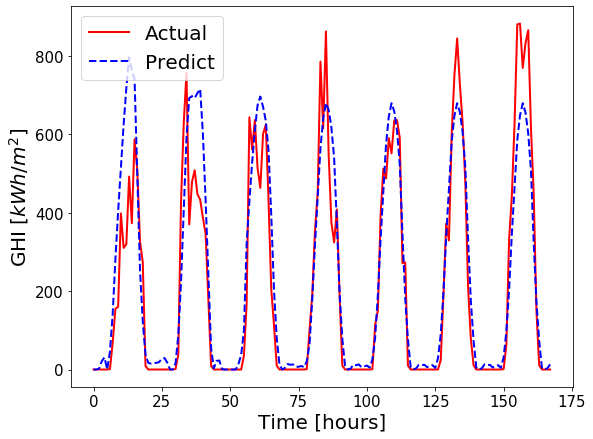

Root mean square error:  111.89011935610672
Mean absolute error:  69.61309523809524
R-Squared:  0.827933020681965


In [99]:
predict = 672*7
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01092017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

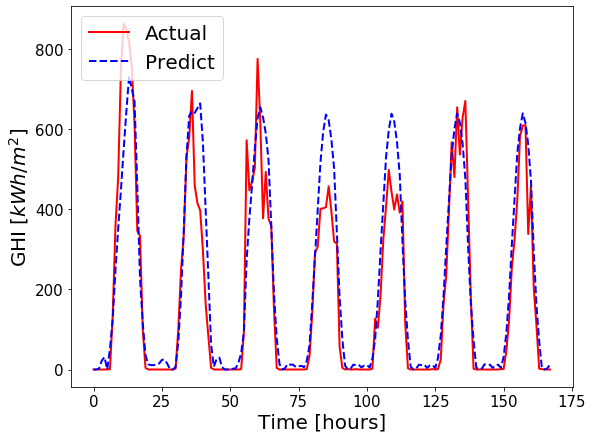

Root mean square error:  93.36490749945052
Mean absolute error:  58.208333333333336
R-Squared:  0.8495076347380806


In [100]:
predict = 672*8
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01102017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

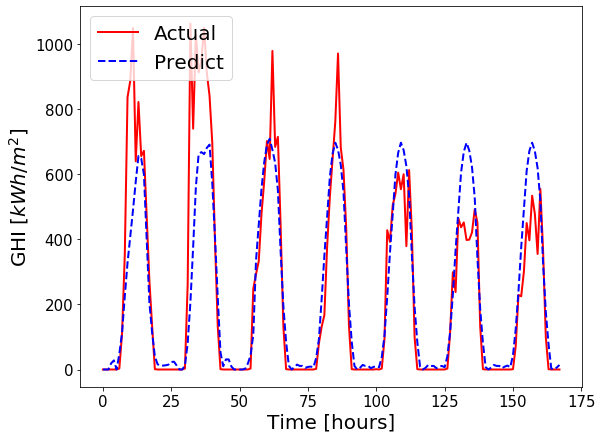

Root mean square error:  145.38342163298498
Mean absolute error:  79.875
R-Squared:  0.7790343728735198


In [101]:
predict = 672*9
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01112017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

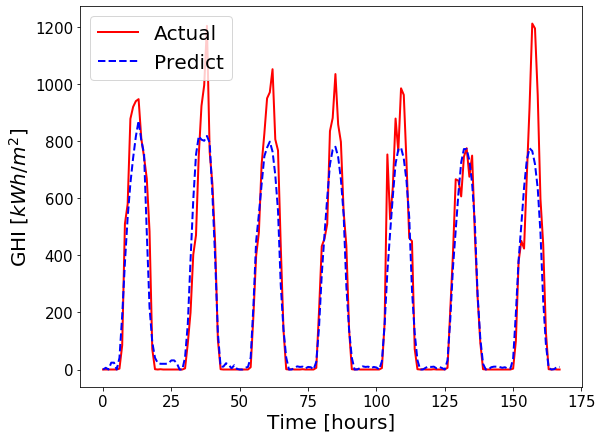

Root mean square error:  111.9413643280224
Mean absolute error:  64.58333333333333
R-Squared:  0.9080655549074431


In [102]:
predict = 672*10
x_input = X_test_[predict].reshape((1, n_steps_in_w, n_features))
yhat_norm_w = model_w.predict(x_input, verbose=0)
yhat_w = scaler.inverse_transform(yhat_norm_w)
yhat_w = yhat_w[0]
pred = pd.DataFrame(np.round(yhat_w))
pred = pred.replace(pred[pred[0]<=0],0)
yhat_w = np.array(pred)

actual = y_test[predict]
# a = var[predict-48:predict]
# b = np.hstack((a,actual))

plt.rcParams['figure.figsize'] = (9, 7)
plt.plot(actual,'r',  label='Actual', linewidth=2)
plt.plot(yhat_w.ravel(),'b--',  label='Predict', linewidth=2)
plt.legend(loc='upper left', fontsize=20)
plt.xlabel("Time [hours]", fontsize=20)
plt.ylabel("GHI $[kWh/m^2]$", fontsize=20)
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig('Figuras_Informe/predict_week_01122017.pdf', format='pdf', dpi=300)
plt.show() 

rmse = np.sqrt(mean_squared_error(actual, yhat_w))
mae = mean_absolute_error(actual, yhat_w)
r2 = r2_score(actual, yhat_w)

print('Root mean square error: ', rmse)
print('Mean absolute error: ', mae)
print('R-Squared: ', r2)

In [79]:
model_w.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 168)               114912    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 168, 168)          0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 168, 168)          227136    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 168, 1)            169       
Total params: 342,217
Trainable params: 342,217
Non-trainable params: 0
_________________________________________________________________


## 4. Save Models

In [49]:
from keras.models import model_from_json

# save daily model
model_json_d = model_d.to_json()
with open("model_d.json", "w") as json_file:
    json_file.write(model_json_d)
model_d.save_weights("model_d.h5")

# save weekly model
model_json_w = model_w.to_json()
with open("model_w.json", "w") as json_file:
    json_file.write(model_json_w)
model_w.save_weights("model_w.h5")

In [17]:
# Load the model
from keras.models import model_from_json
json_file = open('model_d.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model_d.h5")
loaded_model.compile(optimizer='adam', loss='mse')
# score = loaded_model.evaluate(x_input, yhat_norm, verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
